# Workshop 6

Starter code for workshop 6. You should have seen most of it before, but make sure you understand what it is doing!

In [1]:
# General libraries
import sklearn
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To plot even prettier figures
import seaborn as sn

# General data handling (pure numerics are better in numpy)
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
xarray = data.data
yarray = data.target
fullarray = np.concatenate((xarray,np.reshape(yarray,(-1,1))),axis=1)

In [4]:
fullarray[:,-1] = 1 - fullarray[:,-1]   # now invert the labels (so that malignant=1)
# Here we also make a version as a pandas dataframe for exploration of the data, but remember to 
#   use a numpy format for all numerical machine learning operations
df = pd.DataFrame(fullarray,columns = list(data.feature_names) + ['target'])

# Splitting into separate datasets

In [5]:
from sklearn.model_selection import train_test_split

# display(fullarray)
# display(fullarray[:,-1])

# Split data
bigtrain_set, test_set = train_test_split(fullarray, test_size=0.15, random_state=42, stratify=fullarray[:,-1])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.2, random_state=42, stratify=bigtrain_set[:,-1])

In [6]:
# Generate our final data
X_train = train_set[:,:-1]
y_train = train_set[:,-1]
X_test = test_set[:,:-1]
y_test = test_set[:,-1]
X_val = val_set[:,:-1]
y_val = val_set[:,-1]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes are [(386, 30), (386,), (86, 30), (86,), (97, 30), (97,)]


# Base Pipeline

In [7]:
# Load libraries related to pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Create my base pipeline
preproc_pl = Pipeline([ ('imputer', SimpleImputer(strategy="median")), 
                        ('std_scaler', StandardScaler()) ])

# Initial SVM Classifier

In [8]:
# Load specific libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, hinge_loss
from sklearn.metrics import roc_curve, auc

# Create a new pipeline with SVC and a specific kernel
svm_pl = Pipeline([('preproc',preproc_pl), ('svc',SVC(kernel='linear'))])

# Train
svm_pl.fit(X_train,y_train)
# Predict
y_val_pred = svm_pl.predict(X_val)
# Results
acc = accuracy_score(y_val,y_val_pred)
print(acc)

0.9690721649484536


# Simple Baseline

In [9]:
# We go to create a for loop to define a baseline
for n in range(X_train.shape[1]):
    # Select a feature
    xfeat = X_train[:,n]
    xmin = np.min(xfeat)
    xmax = np.max(xfeat)
    # Create a 'prediction' for each feature
    y_pred = (xfeat-xmin)/(xmax-xmin)     # this is similar to minmaxscaler. Consider that y_pred is the prob to belong to the positive class
    # Get the fpr and tpr
    # display("y_train: ", y_train)
    # display("y_pred: ", y_pred)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label=1)
    # Get the AUC score
    aucval = auc(fpr,tpr)
    # Now, we go to try different thresholds.
    acc = 0
    best_threshold = 0
    # We go to try multiple thresholds iterating over all the values given in each feature
    for testing_threshold in y_pred:
        # Finally we go to save the case with the maximum accuracy in train
        acc_new = np.max([acc, accuracy_score(y_train, y_pred>testing_threshold)])
        if acc_new > acc:
            best_threshold = testing_threshold
        # Leave the best accuracy value
        acc = acc_new
    print(f'AUC for feature {n} = {aucval} ; Max accuracy = {acc} using {best_threshold} as a threshold')

AUC for feature 0 = 0.9297090220385674 ; Max accuracy = 0.8860103626943006 using 0.38141890292962277 as a threshold
AUC for feature 1 = 0.7748507805325988 ; Max accuracy = 0.7357512953367875 using 0.3222861007778153 as a threshold
AUC for feature 2 = 0.9387195821854913 ; Max accuracy = 0.8860103626943006 using 0.36390021422154656 as a threshold
AUC for feature 3 = 0.930412075298439 ; Max accuracy = 0.8911917098445595 using 0.2333828207847296 as a threshold
AUC for feature 4 = 0.7276601239669422 ; Max accuracy = 0.6917098445595855 using 0.5411018530033579 as a threshold
AUC for feature 5 = 0.852071854912764 ; Max accuracy = 0.7953367875647669 using 0.24431606410734252 as a threshold
AUC for feature 6 = 0.9211145546372819 ; Max accuracy = 0.8652849740932642 using 0.22626522961574508 as a threshold
AUC for feature 7 = 0.9536128328741966 ; Max accuracy = 0.8989637305699482 using 0.27773359840954276 as a threshold
AUC for feature 8 = 0.6692062672176309 ; Max accuracy = 0.6865284974093264 us

# ROC Curve

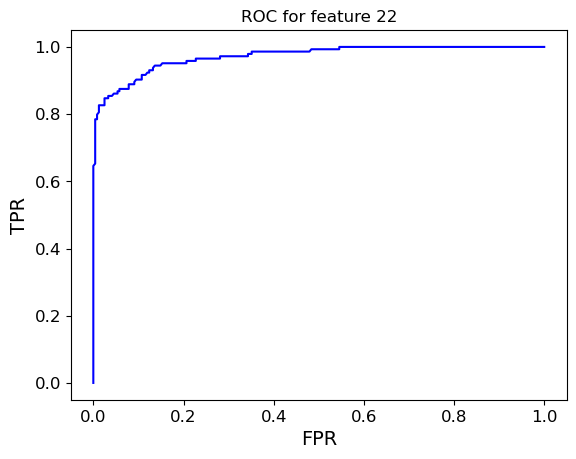

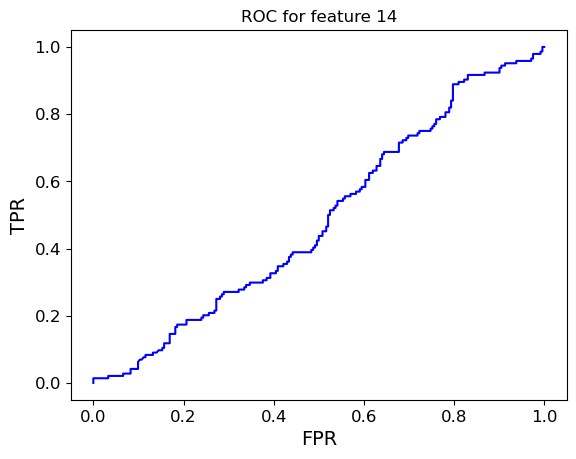

In [10]:
# Repeat the previous process
for n in [22, 14]:  # Select the best and worst feature numbers, respectively
    xfeat = X_train[:,n]
    xmin = np.min(xfeat)
    xmax = np.max(xfeat)
    y_pred = (xfeat-xmin)/(xmax-xmin)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label=1)
    # Plot ROC
    plt.plot(fpr,tpr,'b')
    plt.title(f'ROC for feature {n}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

# Decision Boundaries with linear kernel

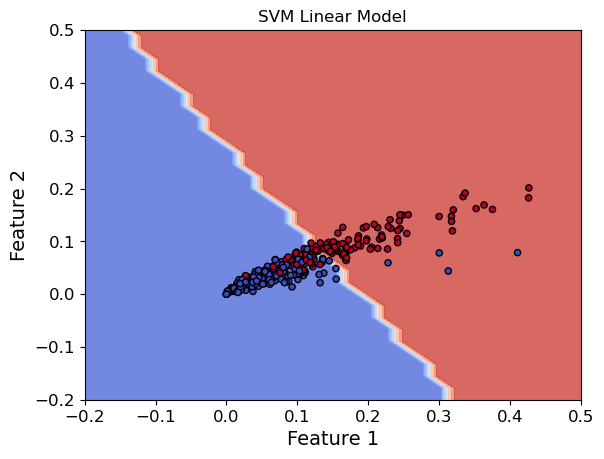

In [11]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay

# Create a new pipeline with SVC and a specific kernel
svm_model = SVC(kernel='linear', C = 1) # C = regularization parameter

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = X_train[:, 6], X_train[:, 7]

# Train again our model using only the two features 
svm_model.fit(X_train[:,6:8],y_train)

# We can plot a DecisionBoundaary
disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,                            # Define the model
    train_set[:,6:8],                     # Define the data
    response_method="predict",            # Define the method used to create the boundary
    cmap=plt.cm.coolwarm,                 # Color palette
    alpha=0.8,                            # Transparency
    xlabel= "Feature 1",                  # Label 1
    ylabel= "Feature 2")                  # Label 2
# We can plot the data with its true classes
plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

# Define the limit values of the plot
plt.xlim([-0.2,0.5])
plt.ylim([-0.2,0.5])
plt.title("SVM Linear Model")
plt.show()

In [12]:
# If you have problems running the function DecisionBoundaryDisplay, tries to run the next piece of code in terminal

# !pip install -U scikit-learn

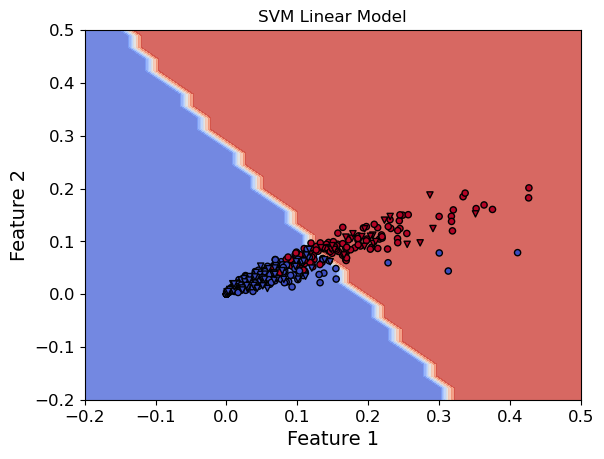

In [13]:
# We can do the same but now, we can add the prediction in our validation set
svm_model = SVC(kernel='linear', C = 1)

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = X_train[:,6], X_train[:, 7]
feat1_val, feat2_val = X_val[:, 6], X_val[:, 7]

# Train again our model using only the two features 
svm_model.fit(X_train[:,6:8],y_train)

# We can plot a DecisionBoundaary
disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,                            
    train_set[:,6:8],                     
    response_method="predict",            
    cmap=plt.cm.coolwarm,                 
    alpha=0.8,                           
    xlabel= "Feature 1",                  
    ylabel= "Feature 2")                  

# We can plot the data with its true classes
plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
# We add the prediction in validation
plt.scatter(feat1_val,feat2_val, c = svm_model.predict(val_set[:,6:8]), cmap=plt.cm.coolwarm, s=20, edgecolors="k",marker = "v")

# Define the limit values of the plot
plt.xlim([-0.2,0.5])
plt.ylim([-0.2,0.5])
plt.title("SVM Linear Model")
plt.show()

# Additional SVM Classifiers

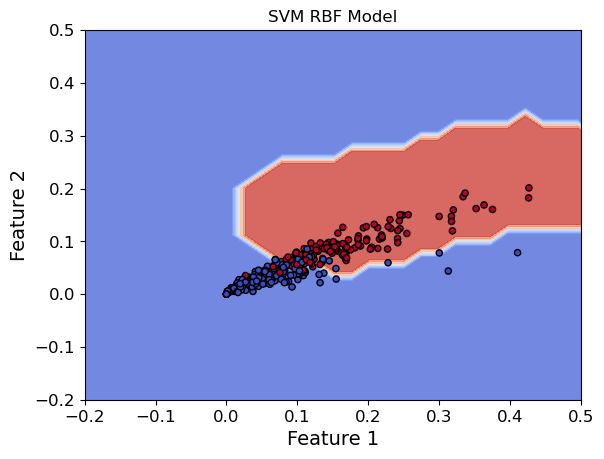

In [14]:
# Create SVC RBF (Radial) kernel model
svm_model = svm.SVC(kernel="rbf", C = 1)

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = X_train[:, 6], X_train[:, 7]

# Train again our model using only the two features 
svm_model.fit(X_train[:,6:8],y_train)

disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,
    train_set[:,6:8],
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.8,
    xlabel= "Feature 1",
    ylabel= "Feature 2")

plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.xlim([-0.2,0.5])
plt.ylim([-0.2,0.5])
plt.title("SVM RBF Model")
plt.show()

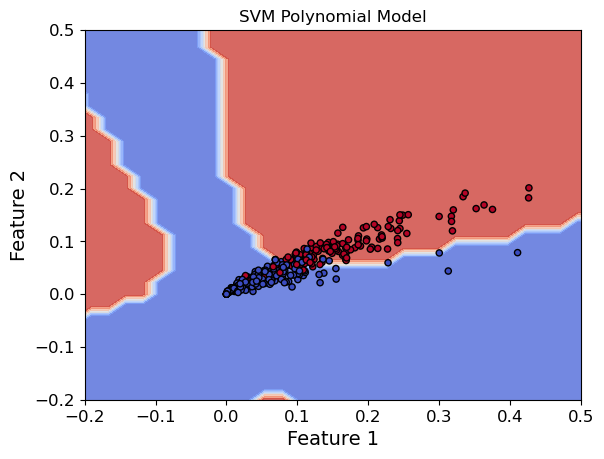

In [15]:
# Create Polnomial kernel model
svm_model = svm.SVC(kernel="poly", degree = 3, C = 1)  # Here you can see a clearer effect of C. 
# A low C value makes the decision surface smooth
# A higher value of C, it makes a complex model, fitting better to the train data.

# Define two features. We go to use the best two features identified in the previous step
feat1, feat2 = X_train[:, 6], X_train[:, 7]

# Train again our model using only the two features 
svm_model.fit(X_train[:,6:8],y_train)

disp = DecisionBoundaryDisplay.from_estimator(
    svm_model,
    train_set[:,6:8],
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.8,
    xlabel= "Feature 1",
    ylabel= "Feature 2")

plt.scatter(feat1, feat2, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
plt.xlim([-0.2,0.5])
plt.ylim([-0.2,0.5])
plt.title("SVM Polynomial Model")
plt.show()